In [24]:
# import necessary modules
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from scipy import stats
from scipy.special import erfc
from scipy.signal import gaussian
from scipy.ndimage import convolve1d
import peakutils
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import random
from random import shuffle
import pickle
import copy
from src.codonTable import codonTable
from src.codonUtils import utils
from src.thunderflask import thunderflask
from src.bacteria import strain

sns.set_context("paper")
# get fast fail table
ff_path = '/home/jonathan/Dropbox/Lab/Fast Fail/res/Isaac-pickle-jar/FFpickles/'
with open(ff_path+'ff20_table.pickle', 'rb') as handle:
    fftable = codonTable(table=pickle.load(handle))
# get ff16 table
with open(ff_path+'ff16_table.pickle', 'rb') as handle:
    ff16_table = codonTable(table=pickle.load(handle))
# get reductionist code 
with open('/home/jonathan/Lab/Fast Fail/res/Reductionist Code/reductionist20.pickle', 'rb') as handle:
    red20 = codonTable(pickle.load(handle))

# get reduct15 code
with open('/home/jonathan/Lab/Fast Fail/res/Reductionist Code/reductionist15.pickle', 'rb') as handle:
    red15 = codonTable(pickle.load(handle))

# get random table
with open('res/random_table_manuscript.pickle', 'rb') as handle:
    rand = codonTable(table=pickle.load(handle))
# get standard code
sc = codonTable()  
# get colorado code
col = codonTable(table=utils.coloradoTable)

# define colors
orange = '#ef6c00'
blue = '#2196f3'
green = '#008000'

### Generate Random Tables

In [5]:
# define number of trials to run
N = 1000000
# preallocate memory for statistics
silencicities = np.zeros(N)
mutabilities = np.zeros(N)
# perform N trials
for i in tqdm(range(N)):
    # generage graph
    ct = utils.randomTable(wobble_rule='unrestricted')
    silencicities[i] = utils.silencicity(ct)
    mutabilities[i] = utils.mutability(ct)


100%|██████████| 1000000/1000000 [13:09<00:00, 1265.92it/s]


NameError: name 'rand_silencicities' is not defined

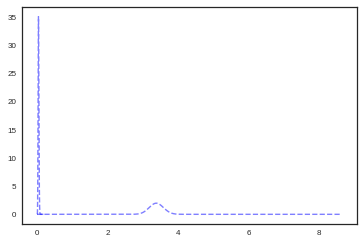

In [12]:
# perform fitting for two distributions
def fitter(array):
    # fit data
    s, loc, scale = stats.lognorm.fit(array)
    x = np.linspace(0, 2*max(array), 1000)
    pdf_fit = stats.lognorm.pdf(x, s, loc=loc, scale=scale)
    params = [s, loc, scale]
    plt.plot(x, pdf_fit, '--b', alpha=0.5, label='Fit')
    return x, pdf_fit, params
x_silence, pdf_silence, param_silence = fitter(silencicities)
x_mutate, pdf_mutate, param_mutate = fitter(mutabilities)

In [13]:
# pickle data for data permanence
to_dump = [silencicities, x_silence, pdf_silence, param_silence,
           mutabilities, x_mutate, pdf_mutate, param_mutate]
with open('res/fig1d.pickle', 'wb') as handle:
    pickle.dump(to_dump, handle)

## Figure 1: Genetic Codes Can Be Optimized for Desired Evolutionary Dynamics 

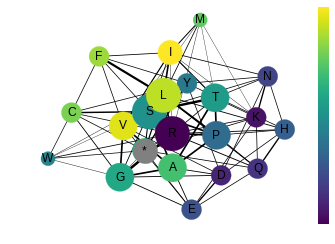

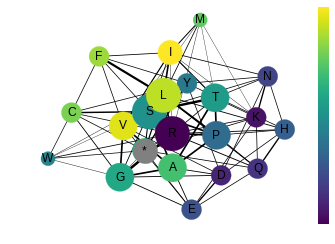

In [11]:
################
# Figures 1a-c #
################

# plot and save some shiznit
path = '/home/jonathan/Lab/Fast Fail/Figures/Figure 1/'
#rand.plotGraph(filename=path+'rand_graph.svg')
sc.plotGraph()#filename=path+'sc_graph.svg')
#col.plotGraph(filename=path+'col_graph.svg')

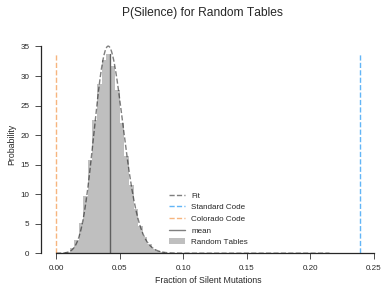

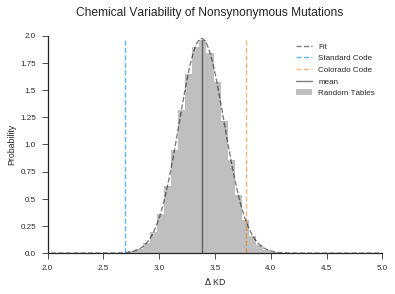

In [34]:
################
# Figures 1d-e #
################

# get data from pickle
with open('res/fig1d.pickle', 'rb') as handle:
    [silencicities, x_silence, pdf_silence, param_silence,
    mutabilities, x_mutate, pdf_mutate, param_mutate] = pickle.load(handle)
    
# Silencicity

# control aesthetics
sns.set_style('white')
sns.set_style('ticks')

# faster version of Silence plot: for when the values have already been calculated
#weights = np.ones(len(silencicities))/len(silencicities)
n, bins, patches = plt.hist(silencicities, 30, normed=1, #weights=weights,
                            color='grey', alpha=0.5, label='Random Tables')
plt.suptitle('P(Silence) for Random Tables')
plt.xlabel('Fraction of Silent Mutations')
plt.ylabel('Probability')
# fit data
def plotfit(x, pdf_fit):
    plt.plot(x, pdf_fit, '--k', alpha=0.5, label='Fit')
    return pdf_fit
plotfit(x_silence, pdf_silence)
#plt.xscale('log')
# define function for plotting individual lines given codonDict
def silentLiner(table, n, color, alpha, label):
    # calculate silencicities
    Silencicity = utils.silencicity(table.codonDict)
    Xs = np.ones(100)*Silencicity
    Ys = np.linspace(0, max(n), len(Xs))
    plt.plot(Xs, Ys, '--', color=color, alpha=alpha, label=label)
# plot line showing Standard Code
silentLiner(sc, n, blue, 0.7, 'Standard Code')
# plot line showing colorado code
silentLiner(col, n, orange, 0.5, 'Colorado Code')
#plot line showing random table
value = silencicities.mean()
Xs = np.ones(100)*value
Ys = np.linspace(0, max(n), len(Xs))
plt.plot(Xs, Ys, '-', color='black', alpha=0.5, label='mean')
#plt.xlim([0, 0.25])
fig = plt.gcf()
ax = plt.gca()
#h, l = ax.get_legend_handles_labels()
#h = [h[-1], h[0], h[1]]
#l = [l[-1], l[0], l[1]]
ax.legend()#h, l)
sns.despine(trim=True)
#plt.savefig('/home/jonathan/Dropbox/Lab/Fast Fail/Figures/Figure 1/silencicity.svg', bbox_inches='tight')
plt.show()

# Mutability

# faster version of Silence plot: for when the values have already been calculated
#weights = np.ones(len(silencicities))/len(silencicities)
n, bins, patches = plt.hist(mutabilities, 30, normed=1, #weights=weights,
                            color='grey', alpha=0.5, label='Random Tables')
plt.suptitle('Chemical Variability of Nonsynonymous Mutations')
plt.xlabel(r'$\Delta$ KD')
plt.ylabel('Probability')
# fit data
plotfit(x_mutate, pdf_mutate)
#plt.xscale('log')
# define function for plotting individual lines given codonDict
def silentLiner2(table, n, color, alpha, label):
    # calculate silencicities
    mutability = utils.mutability(table.codonDict)
    Xs = np.ones(100)*mutability
    Ys = np.linspace(0, max(n), len(Xs))
    plt.plot(Xs, Ys, '--', color=color, alpha=alpha, label=label)
# plot line showing Standard Code
silentLiner2(sc, n, blue, 0.7, 'Standard Code')
# plot line showing colorado code
silentLiner2(col, n, orange, 0.5, 'Colorado Code')
#plot line showing random table
value = mutabilities.mean()
Xs = np.ones(100)*value
Ys = np.linspace(0, max(n), len(Xs))
plt.plot(Xs, Ys, '-', color='black', alpha=0.5, label='mean')
# format ticks
loc, __ = plt.yticks()
ylabels = ['{0}'.format(num/4) for num in range(9)]
plt.yticks(loc, ylabels)
fig = plt.gcf()
ax = plt.gca()
#h, l = ax.get_legend_handles_labels()
#h = [h[-1], h[0], h[1]]
#l = [l[-1], l[0], l[1]]
ax.legend()#h, l
sns.plt.ylim(0,2)
sns.plt.xlim(2,5)
sns.despine()
plt.savefig('/home/jonathan/Dropbox/Lab/Fast Fail/Figures/Figure 1/mutability.svg', bbox_inches='tight')
plt.show()

In [28]:
# calculate p value and 1 in foo of standard table silencicity
[s, loc, scale] = param_silence
z = (utils.silencicity(sc.codonDict) - loc) / scale
sig = np.log(z)/s
p = erfc(sig/np.sqrt(2))

oneInFoo = 1 / p
print('1 in {:.2e}'.format(oneInFoo))

1 in 1.01e+24


In [27]:
ticks = ['{0}'.format(num/4) for num in range(8)]
ticks

['0.0', '0.25', '0.5', '0.75', '1.0', '1.25', '1.5', '1.75']

In [50]:
sc_copy = copy.deepcopy(utils.standardTable)
aa_s = utils.residues
block_array = []
# loop over amino acids
for aa in aa_s:
    # get the block associated with that amino acid
    block = dict((key,value) for key, value in sc_copy.items() if value == aa)
    # store in block array
    block_array.append(block)

# loop over blocks
choices = []
for i, block in enumerate(block_array):
    # get choice
    choice = random.choice(list(block))
    # loop over codons in block
    for codon in list(block):
        # set all non-choice codons in block to stop
        if codon != choice: block[codon] = '*'
    # append choice to choices
    choices.append(choice)
print(block_array[3])

{'CUG': '*', 'UUG': '*', 'CUC': '*', 'UUA': 'L', 'CUU': '*', 'CUA': '*'}


## Figure 2: Fast Fail Genetic Codes Can Hinder Evolution

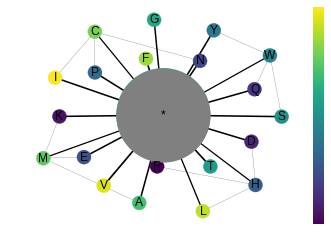

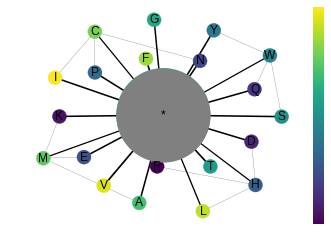

In [10]:
################
# Figures 2a-c #
################

# plot and save some shiznit
path = '/home/jonathan/Lab/Fast Fail/Figures/Figure 2/'
#fftable.codonTable.to_csv(path+'fftable.csv')
fftable.plotGraph()#filename=path+'ff_graph.svg')
#ff16_table.codonTable.to_csv(path+'ff16.csv')
#f16_table.plotGraph(filename=path+'ff16_graph.svg')
# reductionist.plotGraph(weightingFxn=weighter, filename=path+'reductionist_graph.svg')
# reduct16.plotGraph(weightingFxn=weighter, filename=path+'reduct16_graph.svg')

In [15]:
ff16_table.codonGraph.edges(data=True)

[('*', 'T', {'weight': 4.018775720164608e-06}),
 ('*', 'G', {'weight': 4.82253086419753e-05}),
 ('*', 'R', {'weight': 0.75}),
 ('*', 'K', {'weight': 0.006944444444444444}),
 ('*', 'V', {'weight': 0.08333333333333333}),
 ('*', 'F', {'weight': 2.325680393613777e-09}),
 ('*', 'D', {'weight': 2.790816472336533e-08}),
 ('*', 'Q', {'weight': 3.3489797668038396e-07}),
 ('*', 'A', {'weight': 0.75}),
 ('*', 'S', {'weight': 0.75}),
 ('*', 'E', {'weight': 0.75}),
 ('*', 'L', {'weight': 0.75}),
 ('*', 'P', {'weight': 4.5073244110329455e-19}),
 ('*', 'Y', {'weight': 0.75}),
 ('*', 'N', {'weight': 0.75}),
 ('*', 'I', {'weight': 0.75})]

## Figure 3: Evolution is easier to arrest than accelerate 

Iteration Number: : 100%|██████████| 100/100 [00:00<00:00, 678.63it/s]
/usr/local/lib/python3.5/dist-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


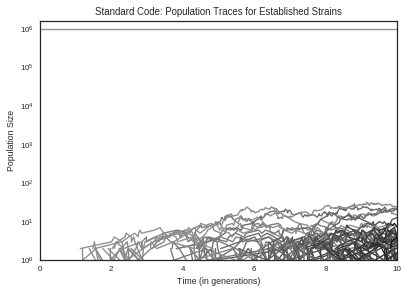

In [7]:
#############
# Figure 3a #
#############

# populate sim
LUCA = strain(N_pop=1e6, fitness=0, mu=2e-5)
sim = thunderflask(LUCA)
# initialize some variables
T_curr = 0
mut_param = [1, 2]
dt = 0.1
T_sim = 100

# run simulation
sim.simulate(T_sim, dt, T_curr, mut_param, save_all=True, prune_strains=True,
             show_progress=True)

n = len(sim.allStrains)
colors = pl.cm.Greys(np.linspace(1,0.5,n))
strainlist = [(i, bact) for i, bact in enumerate(reversed(sim.allStrains))]
shuffle(strainlist)
with sns.axes_style("white"):
    for i, bact in strainlist:
        t = bact.timepoints
        pop = bact.poptrace
        plt.semilogy(t, pop, color=colors[i])
# for i, (key, (times, pops)) in enumerate(sim.poptrace.items()):
#     if i % 10  == 0:
#         plt.semilogy(times, pops, color=colors[i])
plt.xlabel('Time (in generations)')
plt.ylabel('Population Size')
plt.title('Standard Code: Population Traces for Established Strains')
plt.xlim([T_curr, T_sim])
plt.ylim([1e0, 10**(6.2)])
#plt.savefig('/home/jonathan/Lab/Fast Fail/Figures/Figure 3/3a_strain_traces_2.svg')
plt.show()

In [64]:
#############
# Figure 3b #
#############
DF = pd.DataFrame()
filenames = [
    '/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/Standard_Code_1/output/2018-03-23_Standard_Code_1_concatenated.pickle', # standard code
    '/home/jonathan/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/Colorado_0/output/2018-03-23_Colorado_0_concatenated.pickle', # colorado
    '/home/jonathan/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/FF20_0/output/2018-03-23_FF20_0_concatenated.pickle', # FF20
    '/home/jonathan/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/FF16_0/output/2018-03-23_FF16_0_concatenated.pickle', # FF16
    '/home/jonathan/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/Reductionist20_0/output/2018-03-23_Reductionist20_0_concatenated.pickle', # RED20
    '/home/jonathan/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/Reductionist20_0/output/2018-03-23_Reductionist20_0_concatenated.pickle' # RED15
]
# get dataframes
for file in filenames:
    with open(file, 'rb') as handle:
        df = pickle.load(handle)
        df = df[df['time'] < 10]
        DF = pd.concat([DF, df])
        del df
# with open(filenames[0], 'rb') as handle:
#     df = pickle.load(handle)

In [68]:
wanted_codes = ['Standard Code', 'Colorado', 'FF20']
f = lambda code: code in wanted_codes 
DF_3b = DF.loc[DF['code'].map(f)]
DF_3b

,code,fitness,sim,time
0,Standard Code,0.000000e+00,0,0.00000
1,Standard Code,5.284525e-12,0,0.10001
2,Standard Code,5.285053e-08,0,0.20002
3,Standard Code,1.088821e-07,0,0.30003
4,Standard Code,1.393735e-07,0,0.40004
5,Standard Code,1.411763e-07,0,0.50005
6,Standard Code,1.733560e-07,0,0.60006
7,Standard Code,2.011563e-07,0,0.70007
8,Standard Code,2.248946e-07,0,0.80008
9,Standard Code,2.466793e-07,0,0.90009


In [24]:
# optional individual dataframe loading
with open('/home/jonathan/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/Standard_Code_1/output/2018-03-23_Standard_Code_1_concatenated.pickle', 'rb') as handle:
    df = pickle.load(handle)
    df_sc = df[(df['time'] > 100) & (df['time']) < 300]
    # df_sc.set_index(['code', 'sim'], inplace=True)
    del df
    
with open('/home/jonathan/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/Colorado_0/output/2018-03-23_Colorado_0_concatenated.pickle', 'rb') as handle:
    df = pickle.load(handle)
    df_col = df[(df['time'] > 100) & (df['time']) < 300]
    # df_col.set_index(['code', 'sim'], inplace=True)
    del df
    
# with open('/home/jonathan/Dropbox/Lab/ATD/codon-tables/data/manuscript/N=1e6_b=1_l=2/FF20_0/output/2018-03-23_FF20_0_concatenated.pickle', 'rb') as handle:
#     df_ff20_3b = pickle.load(handle)   


/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


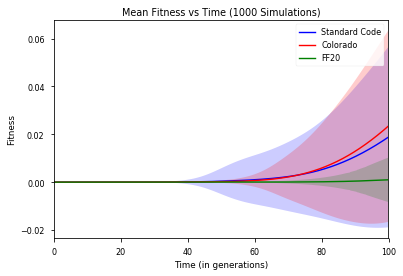

In [15]:
colordict = {
    'Colorado' : 'red',
    'Standard Code' : 'blue',
    'FF20': 'green'
}

ax1 = sns.tsplot(
    data=DF_3b, 
    time='time', 
    value='fitness', 
    unit='sim', 
    condition='code', 
    color=colordict, 
    ci='sd'
)
#ax2 = sns.tsplot(data=df_col_3b, time='time', value='fitness', unit='sim', condition='code', color='red')
#ax3 = sns.tsplot(data=df_ff20_3b, time='time', value='fitness', unit='sim', condition='code', color='green')

plt.legend()
plt.title('Mean Fitness vs Time (1000 Simulations)')
plt.xlabel('Time (in generations)')
plt.ylabel('Fitness')
#plt.savefig('/home/jonathan/Lab/Fast Fail/Figures/Figure 3/3b_fit_traces.pdf')
plt.show()

In [52]:
################
# Figures 3c-d #
################
sims = set(DF_3b['sim'])
codes = set(DF_3b['code'])
lags = []
rates = []
# loop over codes
for code in tqdm(codes, desc='Looping over Codes'):
    # declare storage variables
    t_lag = np.zeros(len(sims))
    rate = np.zeros(len(sims))
    DF = DF_3b.loc[DF_3b['code'] == code]
    for i, sim in enumerate(tqdm(sims, desc='Looping over Sims')):
        # extract data for this sim
        data = DF.loc[DF['sim'] == sim]
        t = data['time'].values
        f = data['fitness'].values
        # smooth with gaussian filter
        gaussian_filter = gaussian(30, 10)
        filtered_signal = convolve1d(f, gaussian_filter/gaussian_filter.sum())
        # calculate first derivative  
        delt = np.diff(t)
        t_avg = (t[1:]+t[:-1])/2
        filt_grad = np.diff(filtered_signal)/delt
        # find peaks
        peak_ind = peakutils.indexes(filt_grad, thres=0.05, min_dist=int(30/delt.mean()))
        # get timestamp for this point
        t_lag[i] = t_avg[peak_ind[0]]
        t_ind = int(peak_ind[0])
        # get estimate for evolutionary rate
        dt = t[-1]  - t[t_ind]
        dx = f[-1] - f[t_ind]
        rate[i] = dx/dt
    # store arrays in list
    lags.append(t_lag)
    rates.append(rate)
           
# collate data into a dataframe
dfs = []
for (lag, rate, code) in zip(lags, rates, codes):
    d = pd.DataFrame({
        'lag' : lag,
        'rate' : rate,
        'code' : [code for i in range(len(lag))]
    })
    dfs.append(d)
DF_3cd = pd.concat(dfs)

HBox(children=(IntProgress(value=0, description='Looping over Codes: ', max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Looping over Sims: ', max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Looping over Sims: ', max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Looping over Sims: ', max=1000), HTML(value='')))

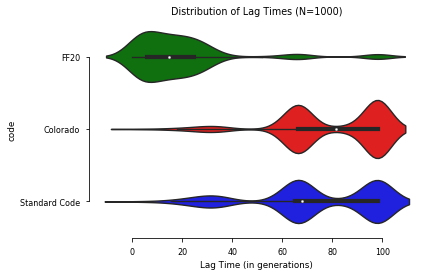

In [70]:
# plot violin plots for lag times
ax = sns.violinplot(
    x='lag', 
    y='code', 
    data=DF_3cd, 
    palette=colordict, 
    inner='box',
)
plt.title('Distribution of Lag Times (N=1000)')
plt.xlabel('Lag Time (in generations)')
sns.despine(trim=True)

#plt.savefig('bonkers.pdf')

Text(0.5,0,'Evolutionary Rates (in 1/generations)')

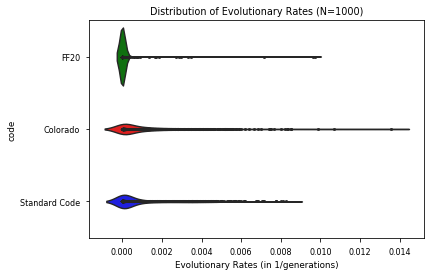

In [41]:
# plot violin plots for lag times
ax = sns.violinplot(x='rate', y='code', data=DF_3cd, palette=colordict, inner='point')
plt.title('Distribution of Evolutionary Rates (N=1000)')
plt.xlabel('Evolutionary Rates (in 1/generations)')
#plt.savefig('bonkers.pdf')

HBox(children=(IntProgress(value=0, description='Looping through codes: ', max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Looping through sims: ', max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Looping through sims: ', max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Looping through sims: ', max=1000), HTML(value='')))

Text(0.5,1,'Distribution of Endpoint Fitnesses')

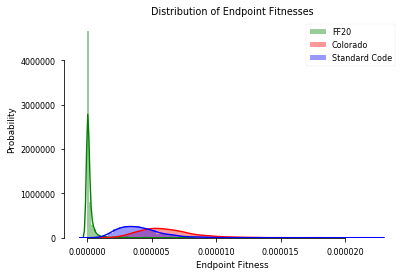

In [75]:
#############
# Figure 3e #
#############
# get endpoint fitness from simulations
endpoints = {}
for code in tqdm(codes, desc='Looping through codes'):
    endpoints[code] = []
    df = DF_3b.loc[DF_3b['code'] == code]
    for sim in tqdm(sims, desc='Looping through sims'):
        endpoints[code].append(df.loc[df['sim'] == sim,'fitness'].iloc[-1])
        sns.despine(trim=True)
DF_endtimes = pd.DataFrame.from_dict(endpoints)

# plot distribution
for code in codes:
    sns.distplot(DF_endtimes[code], kde=True, hist=True, rug=False, norm_hist=True, color=colordict[code], label=code, rug_kws={"alpha" : 0.03})
# plt.xlim([0,0.6])
sns.despine(trim=True)
plt.xlabel('Endpoint Fitness')
plt.ylabel('Probability')
plt.legend()
plt.title('Distribution of Endpoint Fitnesses')


#plt.savefig('Endtime Dist (Hist and KDE).svg')

In [ ]:
##############################################
# Sup Video: Distribution Evolving Over Time #
##############################################
